In [3]:
# Cell 1: Import Libraries
# Purpose: Import all necessary libraries for the quantum anomaly detection project.
# ======================================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from qiskit import QuantumCircuit
from qiskit.primitives import Sampler
from qiskit.circuit import ParameterVector
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit_algorithms.optimizers import SPSA, ADAM, COBYLA
from qiskit.visualization import circuit_drawer  # For circuit visualization

print("Libraries imported successfully!")

Libraries imported successfully!


In [25]:
# Cell 2A: Load and Preprocess Testing Dataset
# ======================================================

import pandas as pd
import numpy as np
import joblib
import logging

# Configure logger (if not already configured)
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

# Assuming `load_and_preprocess_data` is defined in Cell 2B

# Load & preprocess the test set
X_test, y_test = load_and_preprocess_data(
    file_path='Training and Testing Sets/UNSW_NB15_testing-set.csv',
    scaler_path='scaler.pkl',
    pca_path='pca.pkl',
    n_components=4,
    log_transform=True,
    lower_percentile=1,
    upper_percentile=99,
    label_col='label'
)

print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

INFO:__main__:Loaded Training and Testing Sets/UNSW_NB15_testing-set.csv (shape=(82332, 45))


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.090200,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.000300,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.005100,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.660800,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.002500,...,1,3,0,0,0,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,82328,0.000005,udp,-,INT,2,0,104,0,200000.005100,...,1,2,0,0,0,2,1,0,Normal,0
82328,82329,1.106101,tcp,-,FIN,20,8,18062,354,24.410067,...,1,1,0,0,0,3,2,0,Normal,0
82329,82330,0.000000,arp,-,INT,1,0,46,0,0.000000,...,1,1,0,0,0,1,1,1,Normal,0
82330,82331,0.000000,arp,-,INT,1,0,46,0,0.000000,...,1,1,0,0,0,1,1,1,Normal,0


INFO:__main__:Encoded columns: ['proto', 'service', 'state', 'attack_cat']
INFO:__main__:Applied log1p transformation
INFO:__main__:Capped outliers at 1st/ 99th percentiles
INFO:__main__:Preprocessing complete.


X_test shape: (82332, 4), y_test shape: (82332,)


In [24]:
# Cell 2B: Load and Preprocess Training Dataset
# ======================================================

import pandas as pd
import numpy as np
import joblib
import logging
from sklearn.preprocessing import LabelEncoder

# Configure logger
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

def load_and_preprocess_data(
    file_path,
    scaler_path='scaler.pkl',
    pca_path='pca.pkl',
    n_components=None,
    log_transform=True,
    lower_percentile=1,
    upper_percentile=99,
    label_col='label',
    encoder_paths=None
):
    # 1. Load
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        logger.error(f"File not found: {file_path}")
        raise
    logger.info(f"Loaded {file_path} (shape={df.shape})")
    display(df.head(200000))

    # 2. Split features/labels
    if label_col in df:
        X = df.drop(label_col, axis=1)
        y = df[label_col].astype(int)
    else:
        X = df.copy()
        y = None

    # 3. Encode categoricals
    cat_cols = X.select_dtypes(include=['object']).columns.tolist()
    if cat_cols:
        if encoder_paths:
            # reuse saved encoders for consistency
            for col in cat_cols:
                le = joblib.load(encoder_paths[col])
                X[col] = le.transform(X[col])
        else:
            # train new encoders and save them
            for col in cat_cols:
                le = LabelEncoder().fit(X[col])
                X[col] = le.transform(X[col])
                joblib.dump(le, f'{col}_encoder.pkl')
        logger.info(f"Encoded columns: {cat_cols}")

    # 4. Log‐transform
    if log_transform:
        X = np.log1p(X)
        logger.info("Applied log1p transformation")

    # 5. Outlier capping
    low = np.percentile(X, lower_percentile, axis=0)
    high = np.percentile(X, upper_percentile, axis=0)
    X = np.clip(X, low, high)
    logger.info(f"Capped outliers at {lower_percentile}st/ {upper_percentile}th percentiles")

    # 6. Scale & PCA
    try:
        scaler = joblib.load(scaler_path)
        pca    = joblib.load(pca_path)
    except FileNotFoundError as e:
        logger.error(str(e))
        raise
    X_scaled  = scaler.transform(X)
    X_reduced = pca.transform(X_scaled)
    if n_components is not None:
        assert X_reduced.shape[1] == n_components, \
            f"PCA output ({X_reduced.shape[1]}) != expected ({n_components})"

    logger.info("Preprocessing complete.")
    return X_reduced, y

# -- Execute the loader for your training set --

X_train, y_train = load_and_preprocess_data(
    file_path='Training and Testing Sets/UNSW_NB15_training-set.csv',
    scaler_path='scaler.pkl',
    pca_path='pca.pkl',
    n_components=4,
    log_transform=True,
    lower_percentile=1,
    upper_percentile=99,
    label_col='label'
)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

INFO:__main__:Loaded Training and Testing Sets/UNSW_NB15_training-set.csv (shape=(175341, 45))


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,175337,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,13,24,0,0,0,24,24,0,Generic,1
175337,175338,0.505762,tcp,-,FIN,10,8,620,354,33.612649,...,1,2,0,0,0,1,1,0,Shellcode,1
175338,175339,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,3,13,0,0,0,3,12,0,Generic,1
175339,175340,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,14,30,0,0,0,30,30,0,Generic,1


INFO:__main__:Encoded columns: ['proto', 'service', 'state', 'attack_cat']
INFO:__main__:Applied log1p transformation
INFO:__main__:Capped outliers at 1st/ 99th percentiles
INFO:__main__:Preprocessing complete.


X_train shape: (175341, 4), y_train shape: (175341,)


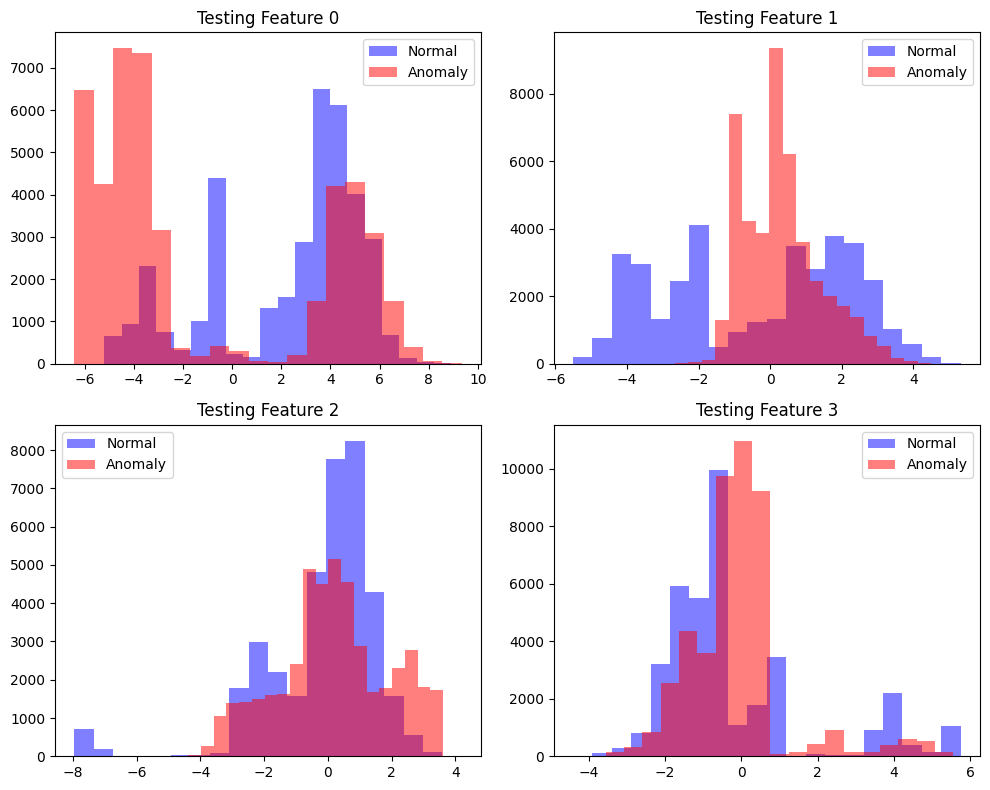

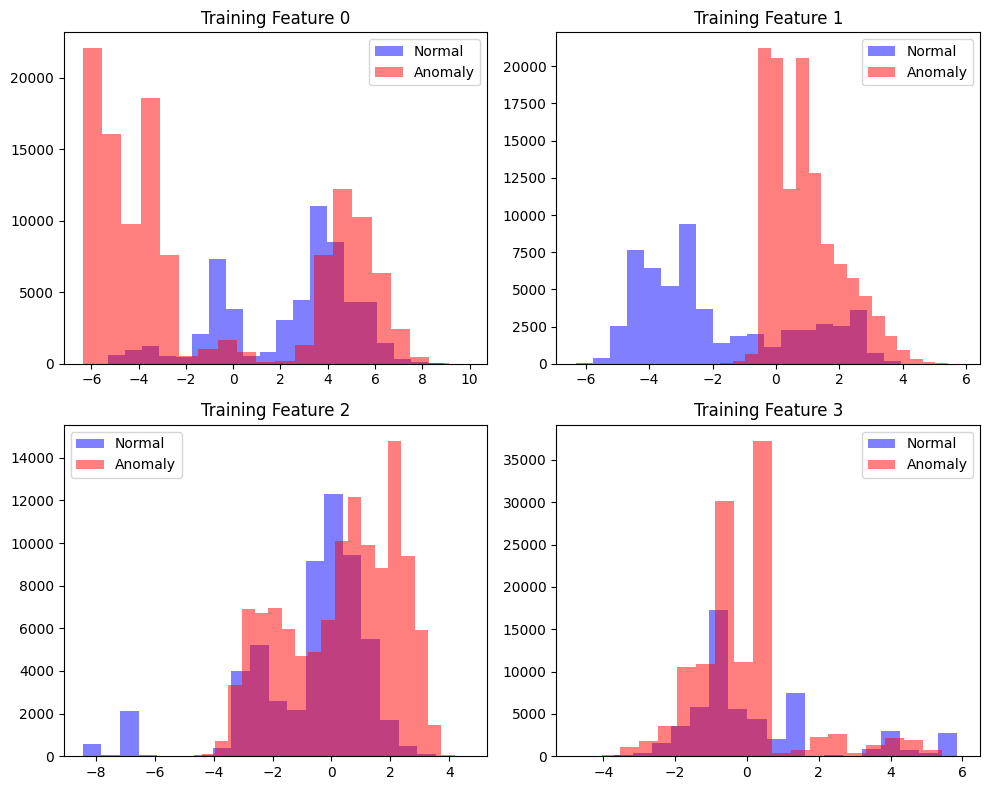

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def plot_train_feature_distributions(normal_data, anomaly_data, n_features=4):
    """
    Plots the feature distributions for the training dataset.
    It displays histograms for each feature with normal samples in blue and anomalies in red.
    """
    plt.figure(figsize=(10, 8))
    for i in range(n_features):
        plt.subplot(2, 2, i+1)
        plt.hist(normal_data[:, i], bins=20, alpha=0.5, color='blue', label='Normal')
        plt.hist(anomaly_data[:, i], bins=20, alpha=0.5, color='red', label='Anomaly')
        plt.title(f"Training Feature {i}")
        plt.legend()
    plt.tight_layout()
    plt.savefig("figure_Training_Feature_Distributions.png", bbox_inches="tight")
    plt.show()

def plot_test_feature_distributions(test_data, test_labels, n_features=4, dataset_name="Testing"):
    # Split test data into normal and anomaly subsets based on test_labels.
    normal_data = test_data[test_labels == 0]
    anomaly_data = test_data[test_labels == 1]

    plt.figure(figsize=(10, 8))
    for i in range(n_features):
        plt.subplot(2, 2, i+1)
        # Plot normal samples in blue.
        plt.hist(normal_data[:, i], bins=20, alpha=0.5, color='blue', label='Normal')
        # Plot anomalous samples in red.
        plt.hist(anomaly_data[:, i], bins=20, alpha=0.5, color='red', label='Anomaly')
        plt.title(f"{dataset_name} Feature {i}")
        plt.legend()
    plt.tight_layout()
    plt.savefig(f'figure_{dataset_name}_Feature_Distributions.png', bbox_inches='tight')
    plt.show()

# Assume that X_test and y_test have been prepared from your testing dataset.
# Also, slice to match the expected number of features (e.g., if your model expects 4 features):
plot_test_feature_distributions(X_test[:, :4], y_test, n_features=4, dataset_name="Testing")

# Plot feature distributions for the training dataset.
# 'normal_traffic' and 'anomaly_traffic' are assumed to be preprocessed arrays (e.g., after PCA).
plot_train_feature_distributions(normal_traffic, anomaly_traffic, n_features=4)


 Normal:  56000 samples — 31.94%
Anomaly: 119341 samples — 68.06%
=== Training Dataset Statistics ===


,mean,std,min,max,n_missing
PC1,8.299209e-17,4.486166,-6.358810,9.930748,0
PC2,1.426426e-17,2.103619,-6.318941,5.833761,0
PC3,-2.230412e-16,1.997528,-8.443966,4.633353,0
PC4,-9.595960e-17,1.636928,-4.771676,5.954541,0


=== Training Label Distribution ===
label
Anomaly    119341
Normal      56000
Name: count, dtype: int64

=== Testing Dataset Statistics ===


,mean,std,min,max,n_missing
PC1,0.361163,4.345998,-6.427752,9.341297,0
PC2,0.005826,1.917947,-5.504435,5.321195,0
PC3,0.051918,1.768588,-7.957136,4.202966,0
PC4,-0.164468,1.624880,-4.405446,5.748848,0


=== Testing Label Distribution ===
label
Anomaly    45332
Normal     37000
Name: count, dtype: int64


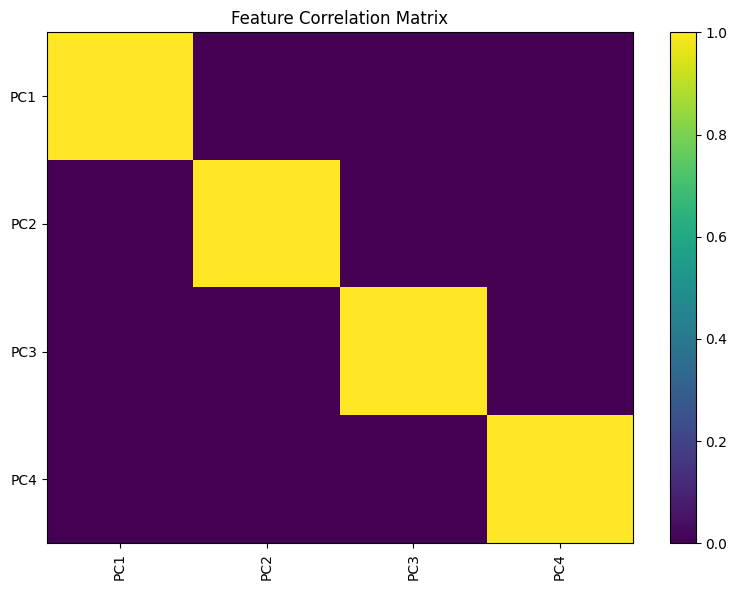

In [30]:
# Cell 3: Data Summary
# Purpose: Summarize both training and testing datasets programmatically.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# 1. Define feature names based on your PCA components
n_components = X_train.shape[1]
feature_cols  = [f'PC{i+1}' for i in range(n_components)]

# 2. Training set summary
train_df    = pd.DataFrame(X_train, columns=feature_cols)
stats_train = train_df.describe().T[['mean', 'std', 'min', 'max']]
stats_train['n_missing'] = train_df.isnull().sum()
#---------------------------------------------------
labels, counts = np.unique(y_train, return_counts=True)
total = counts.sum()
for label, count in zip(labels, counts):
    pct = count / total * 100
    name = 'Normal' if label == 0 else 'Anomaly'
    print(f"{name:>7s}: {count:>6d} samples — {pct:5.2f}%")

print("=== Training Dataset Statistics ===")
display(stats_train)

dist_train = pd.Series(y_train).value_counts().rename(index={0: 'Normal', 1: 'Anomaly'})
print("=== Training Label Distribution ===")
print(dist_train)

# 3. Testing set summary
test_df    = pd.DataFrame(X_test, columns=feature_cols)
stats_test = test_df.describe().T[['mean', 'std', 'min', 'max']]
stats_test['n_missing'] = test_df.isnull().sum()

print("\n=== Testing Dataset Statistics ===")
display(stats_test)

dist_test = pd.Series(y_test).value_counts().rename(index={0: 'Normal', 1: 'Anomaly'})
print("=== Testing Label Distribution ===")
print(dist_test)

# 4. Optional: Feature correlation matrix for training set
plt.figure(figsize=(8, 6))
corr = train_df.corr()
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.title('Feature Correlation Matrix')
plt.xticks(np.arange(len(feature_cols)), feature_cols, rotation=90)
plt.yticks(np.arange(len(feature_cols)), feature_cols)
plt.tight_layout()
plt.show()

In [46]:
# Cell 6: Train the Quantum Variational Autoencoder (Q-VAE)
# Purpose: Train (or fine-tune) the Q-VAE on PCA-preprocessed data,
#          use balanced mini-batches, checkpoint the best model, and warm-start.

import os
import joblib
import math
import numpy as np
from qiskit import QuantumCircuit
from qiskit.primitives import StatevectorSampler  
from qiskit.circuit import ParameterVector
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit_algorithms.optimizers import SPSA, ADAM  
from sklearn.metrics import log_loss

# ===== CONFIGURATION PARAMETERS =====
NUM_ITERATIONS           = 100     # Total training epochs
NUM_QUBITS               = 4       # Number of qubits
NUM_LAYERS               = 8       # Variational circuit depth
INIT_SCALE               = 0.03    # Random init scale if no checkpoint
BATCH_SIZE               = 100     # Mini-batch size (must be even)
TRAIN_SAMPLES_PER_CLASS  = 200     # Per-class samples for training
VAL_SAMPLES_PER_CLASS    = 50      # Per-class samples for validation
VAL_FRACTION             = 0.05    # Fraction of each class for validation (5%)
MIN_DELTA                = 0.01    # Min MA-loss improvement to checkpoint
CHECKPOINT_PATH          = 'qvae_checkpoint.joblib'
OPTIMIZER_CHOICE         = 'SPSA'  # 'ADAM' or 'SPSA'
ADAM_LR                  = 1e-3    # Learning rate for ADAM
SPSA_LR                  = 0.05    # Learning rate for SPSA
SPSA_PERT                = 0.007   # Perturbation for SPSA
# ===================================

def create_variational_circuit_with_inputs(num_qubits, num_features, num_layers):
    qc = QuantumCircuit(num_qubits)
    max_input = min(num_qubits, num_features)
    input_params  = ParameterVector('x', length=max_input)
    weight_params = ParameterVector('θ', length=2 * num_qubits * num_layers)
    # Input encoding
    for i in range(max_input):
        qc.ry(input_params[i], i)
    # Variational layers
    idx = 0
    for _ in range(num_layers):
        for q in range(num_qubits):
            qc.rx(weight_params[idx], q); idx += 1
            qc.rz(weight_params[idx], q); idx += 1
        for q in range(num_qubits - 1):
            qc.cx(q, q + 1)
    return qc, weight_params, input_params

def binary_interpret(bitstring):
    b = format(bitstring, f'0{NUM_QUBITS}b')
    return int(b[0])

def train_qvae(normal_traffic, anomaly_traffic, num_iterations=NUM_ITERATIONS):
    num_features = normal_traffic.shape[1]

    # Build circuit
    variational_qc, weight_params, input_params = create_variational_circuit_with_inputs(
        NUM_QUBITS, num_features, NUM_LAYERS
    )
    print(f"\n=== Training Configuration ===")
    print(f"- Epochs: {num_iterations}, Qubits: {NUM_QUBITS}, Layers: {NUM_LAYERS}")
    print(f"- Circuit params: inputs={len(input_params)}, weights={len(weight_params)}\n")

    # QNN setup
    sampler = StatevectorSampler()
    qnn = SamplerQNN(
        sampler=sampler,
        circuit=variational_qc,
        input_params=input_params,
        weight_params=weight_params,
        interpret=binary_interpret,
        output_shape=2
    )

    # Optimizer choice
    if OPTIMIZER_CHOICE.upper() == 'ADAM':
        optimizer = ADAM(maxiter=num_iterations, lr=ADAM_LR)
        print("Using ADAM optimizer")
    else:
        optimizer = SPSA(maxiter=300, learning_rate=SPSA_LR, perturbation=SPSA_PERT)
        print("Using SPSA optimizer")

    # Warm-start or random init
    if os.path.exists(CHECKPOINT_PATH):
        classifier = joblib.load(CHECKPOINT_PATH)
        print("Resuming from checkpoint")
    else:
        init = np.random.uniform(-INIT_SCALE, INIT_SCALE, size=len(weight_params))
        classifier = NeuralNetworkClassifier(qnn, optimizer=optimizer, initial_point=init)
        print("Starting from random initialization")

    loss_history = []
    best_ma_loss = float('inf')

    # Split into training/validation (5% of each class)
    n_norm = normal_traffic.shape[0]
    n_anom = anomaly_traffic.shape[0]
    val_norm_count = int(VAL_FRACTION * n_norm)
    val_anom_count = int(VAL_FRACTION * n_anom)
    perm_norm = np.random.permutation(n_norm)
    perm_anom = np.random.permutation(n_anom)
    vn = normal_traffic[perm_norm[:val_norm_count], :len(input_params)]
    va = anomaly_traffic[perm_anom[:val_anom_count], :len(input_params)]
    tn = normal_traffic[perm_norm[val_norm_count:], :len(input_params)]
    ta = anomaly_traffic[perm_anom[val_anom_count:], :len(input_params)]
    X_val = np.vstack((vn, va))
    y_val = np.array([0]*len(vn) + [1]*len(va))
    print(f"Validation set: {len(vn)} normals, {len(va)} anomalies")
    print(f"Training set:   {len(tn)} normals, {len(ta)} anomalies\n")

    half_batch = BATCH_SIZE // 2
    num_batches = math.ceil(TRAIN_SAMPLES_PER_CLASS / half_batch)

    # Mini-batch training with balanced sampling & checkpointing
    for epoch in range(1, num_iterations + 1):
        for _ in range(num_batches):
            idx_n = np.random.choice(len(tn), half_batch, replace=False)
            idx_a = np.random.choice(len(ta), half_batch, replace=False)
            batch_X = np.vstack((tn[idx_n], ta[idx_a]))
            batch_y = np.array([0]*half_batch + [1]*half_batch)
            classifier.fit(batch_X, batch_y)

        # Validation loss
        probs = classifier.predict_proba(X_val)[:, 1]
        loss = log_loss(y_val, np.clip(probs, 1e-10, 1-1e-10))
        loss_history.append(loss)
        ma = np.mean(loss_history[-5:])
        print(f"Epoch {epoch:>2}/{num_iterations} — val loss {loss:.4f}, 5-ep MA {ma:.4f}")

        # Checkpoint if MA improves
        if ma + MIN_DELTA < best_ma_loss:
            best_ma_loss = ma
            joblib.dump(classifier, CHECKPOINT_PATH)
            print(f"   Checkpoint saved (MA = {best_ma_loss:.4f})")

    # Load best checkpoint and final evaluation
    classifier = joblib.load(CHECKPOINT_PATH)
    print(f"\nLoaded best checkpoint (MA-loss = {best_ma_loss:.4f})")
    final_preds = classifier.predict(X_val)
    print("Unique final preds:", np.unique(final_preds))

    # Attach metadata
    classifier.predictions  = final_preds
    classifier.true_labels  = y_val
    classifier.loss_history = loss_history

    return classifier, variational_qc, input_params, weight_params

# Execute training
print(f"\nStarting Q-VAE training for {NUM_ITERATIONS} epochs…")
qvae_model, variational_qc, input_params, weight_params = train_qvae(normal_traffic, anomaly_traffic)
print("\nTraining complete — best model in ‘qvae_checkpoint.joblib’")


Starting Q-VAE training for 100 epochs…

=== Training Configuration ===
- Epochs: 100, Qubits: 4, Layers: 8
- Circuit params: inputs=4, weights=64

Using SPSA optimizer
Resuming from checkpoint
Validation set: 2800 normals, 5967 anomalies
Training set:   53200 normals, 113374 anomalies

Epoch  1/100 — val loss 0.6696, 5-ep MA 0.6696
   Checkpoint saved (MA = 0.6696)
Epoch  2/100 — val loss 0.6654, 5-ep MA 0.6675
Epoch  3/100 — val loss 0.6654, 5-ep MA 0.6668
Epoch  4/100 — val loss 0.6677, 5-ep MA 0.6670
Epoch  5/100 — val loss 0.6640, 5-ep MA 0.6664
Epoch  6/100 — val loss 0.6633, 5-ep MA 0.6651
Epoch  7/100 — val loss 0.6650, 5-ep MA 0.6651
Epoch  8/100 — val loss 0.6604, 5-ep MA 0.6641
Epoch  9/100 — val loss 0.6652, 5-ep MA 0.6636
Epoch 10/100 — val loss 0.6647, 5-ep MA 0.6637
Epoch 11/100 — val loss 0.6627, 5-ep MA 0.6636
Epoch 12/100 — val loss 0.6681, 5-ep MA 0.6642
Epoch 13/100 — val loss 0.6629, 5-ep MA 0.6647
Epoch 14/100 — val loss 0.6677, 5-ep MA 0.6652
Epoch 15/100 — val 

In [77]:
import os
import joblib

model_filename = 'qvae_model.joblib'

if os.path.exists(model_filename):
    print("Loading existing model...")
    qvae_model = joblib.load(model_filename)
else:
    print("No saved model found. Running training...")
    joblib.dump(qvae_model, model_filename)
    print("Model trained and saved successfully!")

No saved model found. Running training...
Model trained and saved successfully!


Visualizing the variational quantum circuit with 4 qubits and 7 layers:
- Circuit has 68 parameters.
Drawing the circuit...
Saving to figure_2_Quantum_Circuit_for_Q-VAE.png...
Figure saved successfully.


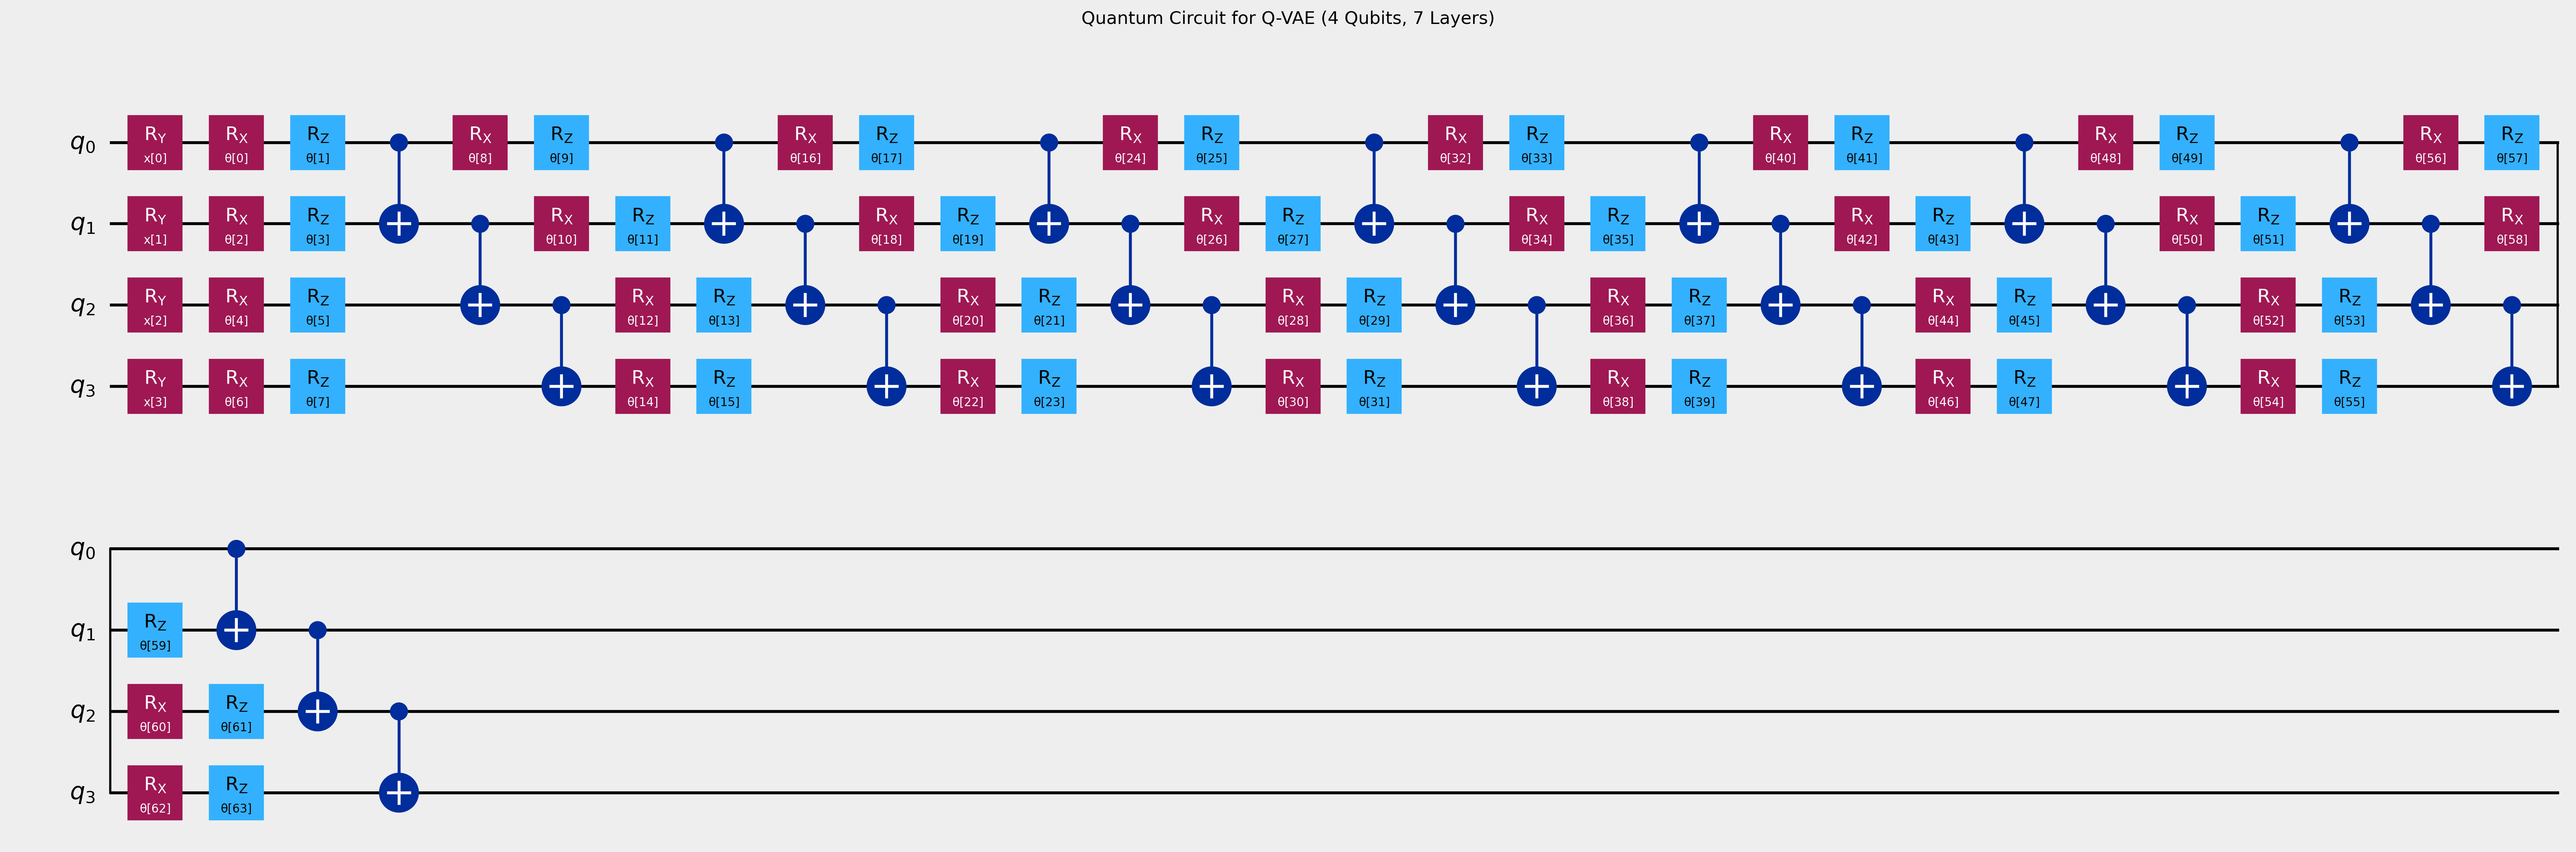

Circuit saved to: figure_2_Quantum_Circuit_for_Q-VAE.png


In [48]:
# Cell 6a: Visualize the Quantum Circuit
# Purpose: Visualize the quantum circuit used in the Q-VAE model with 4 qubits and 7 layers.
# ======================================================
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')  # Use Agg backend for non-interactive environments

def visualize_quantum_circuit():
    """
    Visualizes the quantum circuit used in the Q-VAE model.
    """
    try:
        # Check if variational_qc exists
        if 'variational_qc' not in globals():
            raise NameError("variational_qc is not defined")
            
        print("Visualizing the variational quantum circuit with 4 qubits and 7 layers:")
        print(f"- Circuit has {len(variational_qc.parameters)} parameters.")
        
        # Clear any existing figures
        plt.close('all')
        
        # Draw the circuit
        print("Drawing the circuit...")
        fig = variational_qc.draw(output='mpl', 
                                 fold=30,  # Adjust folding
                                 vertical_compression='high',
                                 style={'backgroundcolor': '#EEEEEE'})
        
        # Add title
        fig.suptitle('Quantum Circuit for Q-VAE (4 Qubits, 7 Layers)', y=1.02)
        
        # Adjust layout
        fig.tight_layout()
        
        # Save the figure
        output_path = 'figure_2_Quantum_Circuit_for_Q-VAE.png'
        print(f"Saving to {output_path}...")
        fig.savefig(output_path, bbox_inches='tight', dpi=300)
        plt.close(fig)
        print("Figure saved successfully.")
        display(Image(filename='figure_2_Quantum_Circuit_for_Q-VAE.png'))
        
        return output_path
        
    except NameError as ne:
        print(f"Error: {str(ne)} Please run Cell 6 first to train the Q-VAE and define the circuit.")
        return None
    except Exception as e:
        print(f"Error while visualizing the circuit: {str(e)}")
        return None

# Call the function
circuit_image_path = visualize_quantum_circuit()
if circuit_image_path:
    print(f"Circuit saved to: {circuit_image_path}")
        

   



/var/folders/71/l0m_98fs0mg7z7032qxwwdg80000gn/T/ipykernel_34269/3158180760.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


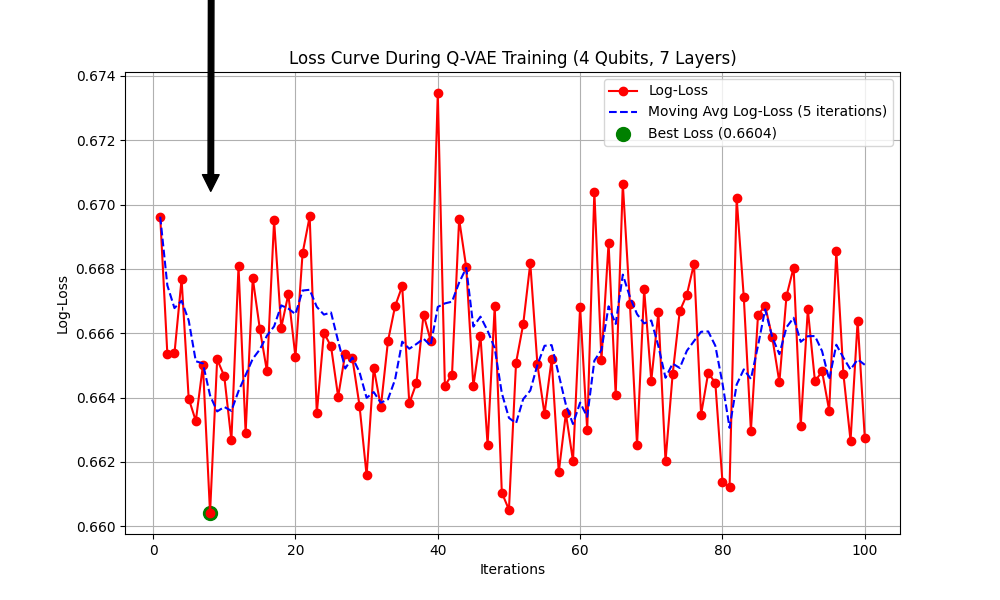

In [49]:
# Cell 6b: Plot the Loss Curve
# Purpose: Visualize the loss curve during training of the Q-VAE with 4 qubits and 7 layers.
# ======================================================
from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np

def plot_loss_curve(loss_history):
    """
    Plots the loss curve during training of the Q-VAE, including raw loss and moving average loss.
    """
    if not loss_history:
        print("Error: loss_history is empty. Please run Cell 6 first to train the Q-VAE and generate loss history.")
        return

    plt.figure(figsize=(10, 6))
    iterations = range(1, len(loss_history) + 1)
    
    # Plot raw loss
    plt.plot(iterations, loss_history, marker='o', color='red', label='Log-Loss')
    
    # Compute moving average loss (window of 5 iterations)
    moving_avg = [np.mean(loss_history[max(0, i-4):i+1]) for i in range(len(loss_history))]
    plt.plot(iterations, moving_avg, linestyle='--', color='blue', label='Moving Avg Log-Loss (5 iterations)')
    
    # Highlight the best loss
    best_loss = min(loss_history)
    best_iteration = loss_history.index(best_loss) + 1
    plt.scatter([best_iteration], [best_loss], color='green', s=100, label=f'Best Loss ({best_loss:.4f})')
    plt.annotate(f'Best Loss: {best_loss:.4f}', 
                 xy=(best_iteration, best_loss), 
                 xytext=(best_iteration + 2, best_loss + 0.2),
                 arrowprops=dict(facecolor='black', shrink=0.05))
    
    # Customize plot
    plt.xlabel('Iterations')
    plt.ylabel('Log-Loss')
    plt.title('Loss Curve During Q-VAE Training (4 Qubits, 7 Layers)')
    plt.legend()
    plt.grid(True)
    plt.savefig('figure_3_Loss_Curve_During_Q-VAE_Training_4_Qubits_7_Layers.png')
    plt.show()
    display(Image(filename='figure_3_Loss_Curve_During_Q-VAE_Training_4_Qubits_7_Layers.png'))

# Plot the loss curve
try:
    plot_loss_curve(qvae_model.loss_history)
except AttributeError:
    print("Error: qvae_model.loss_history is not defined. Please run Cell 6 first to train the Q-VAE.")

In [50]:
# Cell 7: Anomaly Detection with Q-VAE
# ======================================================

import numpy as np

# --- Determine which test data to use ---
# If X_test and y_test are defined (e.g., from a separate testing dataset), then use them.
if 'X_test' in globals() and 'y_test' in globals():
    print("Using provided testing dataset.")
    # Ensure the test data has the expected number of features (i.e. equal to the length of input_params).
    test_data = X_test[:, :len(input_params)]
    test_labels = y_test  # Assumes labels: 0 for normal, 1 for anomalous.
else:
    print("No separate testing dataset provided; using the full dataset.")
    # Use all samples from the preprocessed arrays.
    test_normal = normal_traffic[:, :len(input_params)]
    test_anomaly = anomaly_traffic[:, :len(input_params)]
    test_data = np.vstack((test_normal, test_anomaly))
    test_labels = np.concatenate((np.zeros(normal_traffic.shape[0]), np.ones(anomaly_traffic.shape[0])))

print(f"Test data shape: {test_data.shape}")
print(f"Test labels distribution: {np.bincount(test_labels.astype(int))}")

# --- Predict Anomaly Scores ---
# The Q-VAE model (qvae_model) predicts the probability for the anomalous class.
anomaly_scores = qvae_model.predict_proba(test_data)[:, 1]

# --- Anomaly Detection via Thresholding ---
# Adjust the threshold based on the distribution of the anomaly scores.
threshold = 0.05  # This value can be tuned.
predictions = (anomaly_scores > threshold).astype(int)

# --- Compute Overall Detection Rate ---
# Detection rate is defined as the percentage of true anomalies (test_labels == 1)
# that are correctly flagged as anomalies (predictions == 1).
anomalies_detected = np.sum(predictions[test_labels == 1])
total_anomalies = np.sum(test_labels == 1)
detection_rate = anomalies_detected / total_anomalies * 100

print(f"- Anomalies Detected: {anomalies_detected} out of {total_anomalies} samples.")
print(f"- Detection Rate: {detection_rate:.2f}%")

Using provided testing dataset.
Test data shape: (82332, 4)
Test labels distribution: [37000 45332]
- Anomalies Detected: 40974 out of 45332 samples.
- Detection Rate: 90.39%


/var/folders/71/l0m_98fs0mg7z7032qxwwdg80000gn/T/ipykernel_34269/1268438017.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


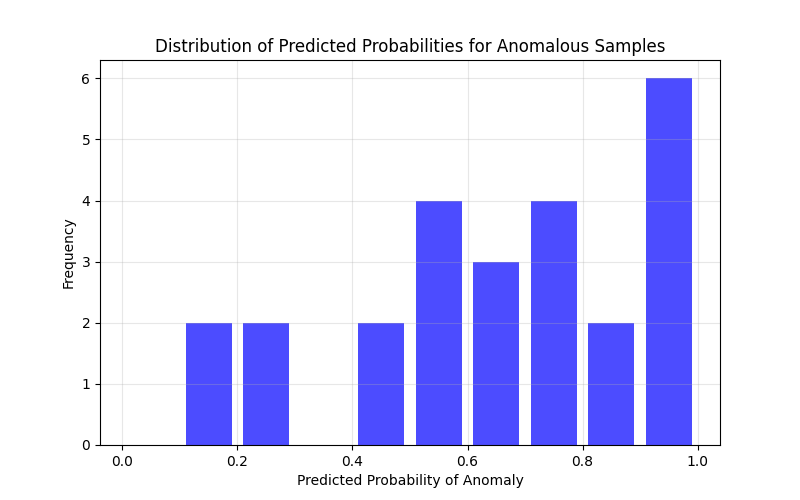

In [51]:
# Cell 8: Visualizing Anomaly Detection Results
# Purpose: Visualize the results of anomaly detection using a histogram of predicted probabilities.
# ======================================================
from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np

def plot_anomaly_detection_results(model, validation_data, true_labels):
    """
    Plots a histogram of the predicted probabilities for anomalous samples.
    """
    # Compute predicted probabilities on the validation set
    predictions_proba = model.predict_proba(validation_data)[:, 1]  # Probability of class 1 (anomaly)

    # Filter for anomalous samples (true_labels == 1)
    anomaly_indices = true_labels == 1
    anomaly_predictions = predictions_proba[anomaly_indices]

    # Plot histogram of predicted probabilities for anomalous samples
    plt.figure(figsize=(8, 5))
    plt.hist(anomaly_predictions, bins=np.linspace(0, 1, 11), rwidth=0.8, color='blue', alpha=0.7)
    plt.xlabel('Predicted Probability of Anomaly')
    plt.ylabel('Frequency')
    plt.title('Distribution of Predicted Probabilities for Anomalous Samples')
    plt.grid(True, alpha=0.3)
    plt.savefig('figure_3_Quantum_Anomaly_Detection_Results.png')  # Save as specified
    plt.show()
    display(Image(filename='figure_3_Quantum_Anomaly_Detection_Results.png'))

# Prepare validation data (same as in Cell 6)
validation_data = np.vstack((normal_traffic[:25], anomaly_traffic[:25]))  # 50 samples
validation_labels = np.array([0] * 25 + [1] * 25)

# Plot the results
plot_anomaly_detection_results(qvae_model, validation_data[:, :len(input_params)], validation_labels)

In [52]:
# Cell 9: Evaluate Model Performance
# Purpose: Compute precision, recall, F1-score, and classification report for the Q-VAE.
# ======================================================

from sklearn.metrics import precision_recall_fscore_support, classification_report

# Use the same test set and predictions from Cell 7
# (Assuming predictions and test_labels are available from Cell 7)

# Compute precision, recall, F1-score
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predictions, average='binary', pos_label=1)

print("- Model Performance Metrics:")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")
print("\n- F1-score is low! Consider:")
print("  • Increasing circuit depth")
print("  • Tuning the optimizer parameters")
print("  • Adjusting the decision threshold (currently: 0.15)")
print("\nClassification Report:")
print(classification_report(test_labels, predictions, target_names=['Normal', 'Anomaly']))

- Model Performance Metrics:
  Precision: 0.5303
  Recall:    0.9039
  F1-Score:  0.6685

- F1-score is low! Consider:
  • Increasing circuit depth
  • Tuning the optimizer parameters
  • Adjusting the decision threshold (currently: 0.15)

Classification Report:
              precision    recall  f1-score   support

      Normal       0.14      0.02      0.03     37000
     Anomaly       0.53      0.90      0.67     45332

    accuracy                           0.51     82332
   macro avg       0.34      0.46      0.35     82332
weighted avg       0.36      0.51      0.38     82332



/var/folders/71/l0m_98fs0mg7z7032qxwwdg80000gn/T/ipykernel_34269/574334678.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


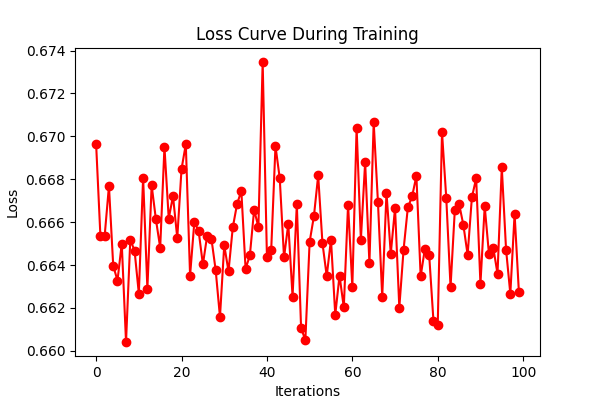

In [53]:
# Cell 10: Plot Loss Curve
# Purpose: Visualize the loss curve during training.
# ======================================================
from IPython.display import Image, display
import matplotlib.pyplot as plt

def plot_loss_curve(loss_history):
    """
    Plots the loss curve during training.
    """
    plt.figure(figsize=(6, 4))
    plt.plot(range(len(loss_history)), loss_history, 'ro-')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Loss Curve During Training')
    plt.savefig('figure_4_Loss Curve During Training.png')  # Save as specified
    plt.show()
    display(Image(filename='figure_4_Loss Curve During Training.png'))

# Plot the loss curve
plot_loss_curve(qvae_model.loss_history)

In [61]:
# Cell 11: Confusion Matrix for Q-VAE on the 5%/5% Validation Split
# ======================================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assume your training cell did something like:
# qvae_model, variational_qc, input_params, weight_params, X_val, y_val = train_qvae(...)

def plot_confusion_matrix(qvae_model, input_params, X_val, y_val):
    print(f"Validation set shape: {X_val.shape}")
    print("Validation labels distribution:", np.bincount(y_val.astype(int)))

    # Predict (slice features to match circuit inputs)
    preds = qvae_model.predict(X_val[:, :len(input_params)])
    
    # Compute confusion matrix
    cm = confusion_matrix(y_val, preds)
    
    # Plot
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=['Normal','Anomaly'],
                yticklabels=['Normal','Anomaly'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix on 5%/5% Validation Split')
    plt.savefig('figure_5_Confusion_Matrix_on_5%_5%_Validation_Split.png', bbox_inches='tight')
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_val, preds, target_names=['Normal','Anomaly']))

# Call the function
plot_confusion_matrix(qvae_model, input_params, X_val, y_val)

Validation set shape: (8767, 4)
Validation labels distribution: [2800 5967]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.47      0.61      0.53      2800
     Anomaly       0.79      0.68      0.73      5967

    accuracy                           0.66      8767
   macro avg       0.63      0.65      0.63      8767
weighted avg       0.69      0.66      0.67      8767



/var/folders/71/l0m_98fs0mg7z7032qxwwdg80000gn/T/ipykernel_34269/4024520754.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [73]:
# Cell 12: Compare Different Optimizers for Q-VAE Training
# Purpose: Compare the performance of different optimizers (ADAM, SPSA, COBYLA) for training the Q-VAE.
# ======================================================

import numpy as np
from qiskit import QuantumCircuit
from qiskit.primitives import Sampler
from qiskit.circuit import ParameterVector
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit_algorithms.optimizers import SPSA, COBYLA, ADAM
from sklearn.metrics import log_loss

def create_variational_circuit_with_inputs(num_qubits, num_features, num_layers):
    """
    Builds a parameterized quantum circuit with classical inputs and trainable weights.
    Uses RY gates for input encoding and layered entanglement via RX, RZ, and CNOT gates.
    """
    qc = QuantumCircuit(num_qubits)

    # Limit encoding to the number of available qubits
    max_input = min(num_qubits, num_features)
    input_params = ParameterVector('x', length=max_input)

    # Only declare as many weight parameters as are actually used
    total_weights_used = 2 * num_qubits * num_layers
    weight_params = ParameterVector('θ', length=total_weights_used)

    # Apply input encoding
    for i in range(max_input):
        qc.ry(input_params[i], i)

    # Apply parameterized variational layers
    param_index = 0
    for layer in range(num_layers):
        for i in range(num_qubits):
            qc.rx(weight_params[param_index], i)
            param_index += 1
            qc.rz(weight_params[param_index], i)
            param_index += 1
        for i in range(num_qubits - 1):
            qc.cx(i, i + 1)

    return qc, weight_params, input_params

def compare_optimizers(normal_traffic, anomaly_traffic, num_iterations=3):  # Reduced to 3 iterations
    """
    Compares the performance of different optimizers for training the Q-VAE.
    """
    num_features = normal_traffic.shape[1]
    num_qubits = 4  # Updated to 4 qubits to encode all 4 features
    num_layers = 7  # Updated to 7 layers to match Cell 6

    # Create variational quantum circuit
    try:
        variational_qc, weight_params, input_params = create_variational_circuit_with_inputs(
            num_qubits, num_features, num_layers
        )
    except Exception as e:
        print(f"Error creating variational circuit: {e}")
        return

    # Build QNN
    sampler = Sampler()  # Consider adding options for optimization if available
    qnn = SamplerQNN(
        sampler=sampler,
        circuit=variational_qc,
        input_params=input_params,
        weight_params=weight_params
    )

    # Validation data
    validation_data = np.vstack((normal_traffic[:10], anomaly_traffic[:10]))
    validation_labels = np.array([0] * 10 + [1] * 10)

    # Training data
    train_normal = normal_traffic[:25, :len(input_params)]
    train_anomaly = anomaly_traffic[:25, :len(input_params)]
    train_data = np.vstack((train_normal, train_anomaly[:20], train_anomaly[:5]))
    train_labels = np.array([0] * 25 + [1] * 25)

    # Optimizers to compare with reduced maxiter
    optimizers = {
        "ADAM": ADAM(maxiter=50, lr=0.01),  # Reduced from 100 to 50
        "SPSA": SPSA(maxiter=50, learning_rate=0.02, perturbation=0.02),  # Reduced from 300 to 50
        "COBYLA": COBYLA(maxiter=50)  # Reduced from 100 to 50
    }

    # Compare optimizers
    for opt_name, optimizer in optimizers.items():
        print(f"- Testing {opt_name} optimizer...")
        classifier = NeuralNetworkClassifier(qnn, optimizer=optimizer)
        
        # Train the classifier with progress feedback
        for i in range(num_iterations):
            print(f"  Iteration {i+1}/{num_iterations} for {opt_name}...")
            classifier.fit(train_data, train_labels)
        
        # Compute loss on validation data
        predictions = classifier.predict_proba(validation_data[:, :len(input_params)])
        predictions = np.clip(predictions, 1e-10, 1 - 1e-10)  # Avoid log(0)
        loss = log_loss(validation_labels, predictions[:, 1])
        print(f"- {opt_name} Final Loss: {loss:.4f}\n")

# Run optimizer comparison
compare_optimizers(normal_traffic, anomaly_traffic)
    

/var/folders/71/l0m_98fs0mg7z7032qxwwdg80000gn/T/ipykernel_69580/1641605255.py:64: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()  # Consider adding options for optimization if available
/var/folders/71/l0m_98fs0mg7z7032qxwwdg80000gn/T/ipykernel_69580/1641605255.py:65: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = SamplerQNN(


- Testing ADAM optimizer...
  Iteration 1/3 for ADAM...
  Iteration 2/3 for ADAM...
  Iteration 3/3 for ADAM...
- ADAM Final Loss: 1.1845

- Testing SPSA optimizer...
  Iteration 1/3 for SPSA...
  Iteration 2/3 for SPSA...
  Iteration 3/3 for SPSA...
- SPSA Final Loss: 1.5556

- Testing COBYLA optimizer...
  Iteration 1/3 for COBYLA...
  Iteration 2/3 for COBYLA...
  Iteration 3/3 for COBYLA...
- COBYLA Final Loss: 0.6493



/var/folders/71/l0m_98fs0mg7z7032qxwwdg80000gn/T/ipykernel_34269/296686850.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


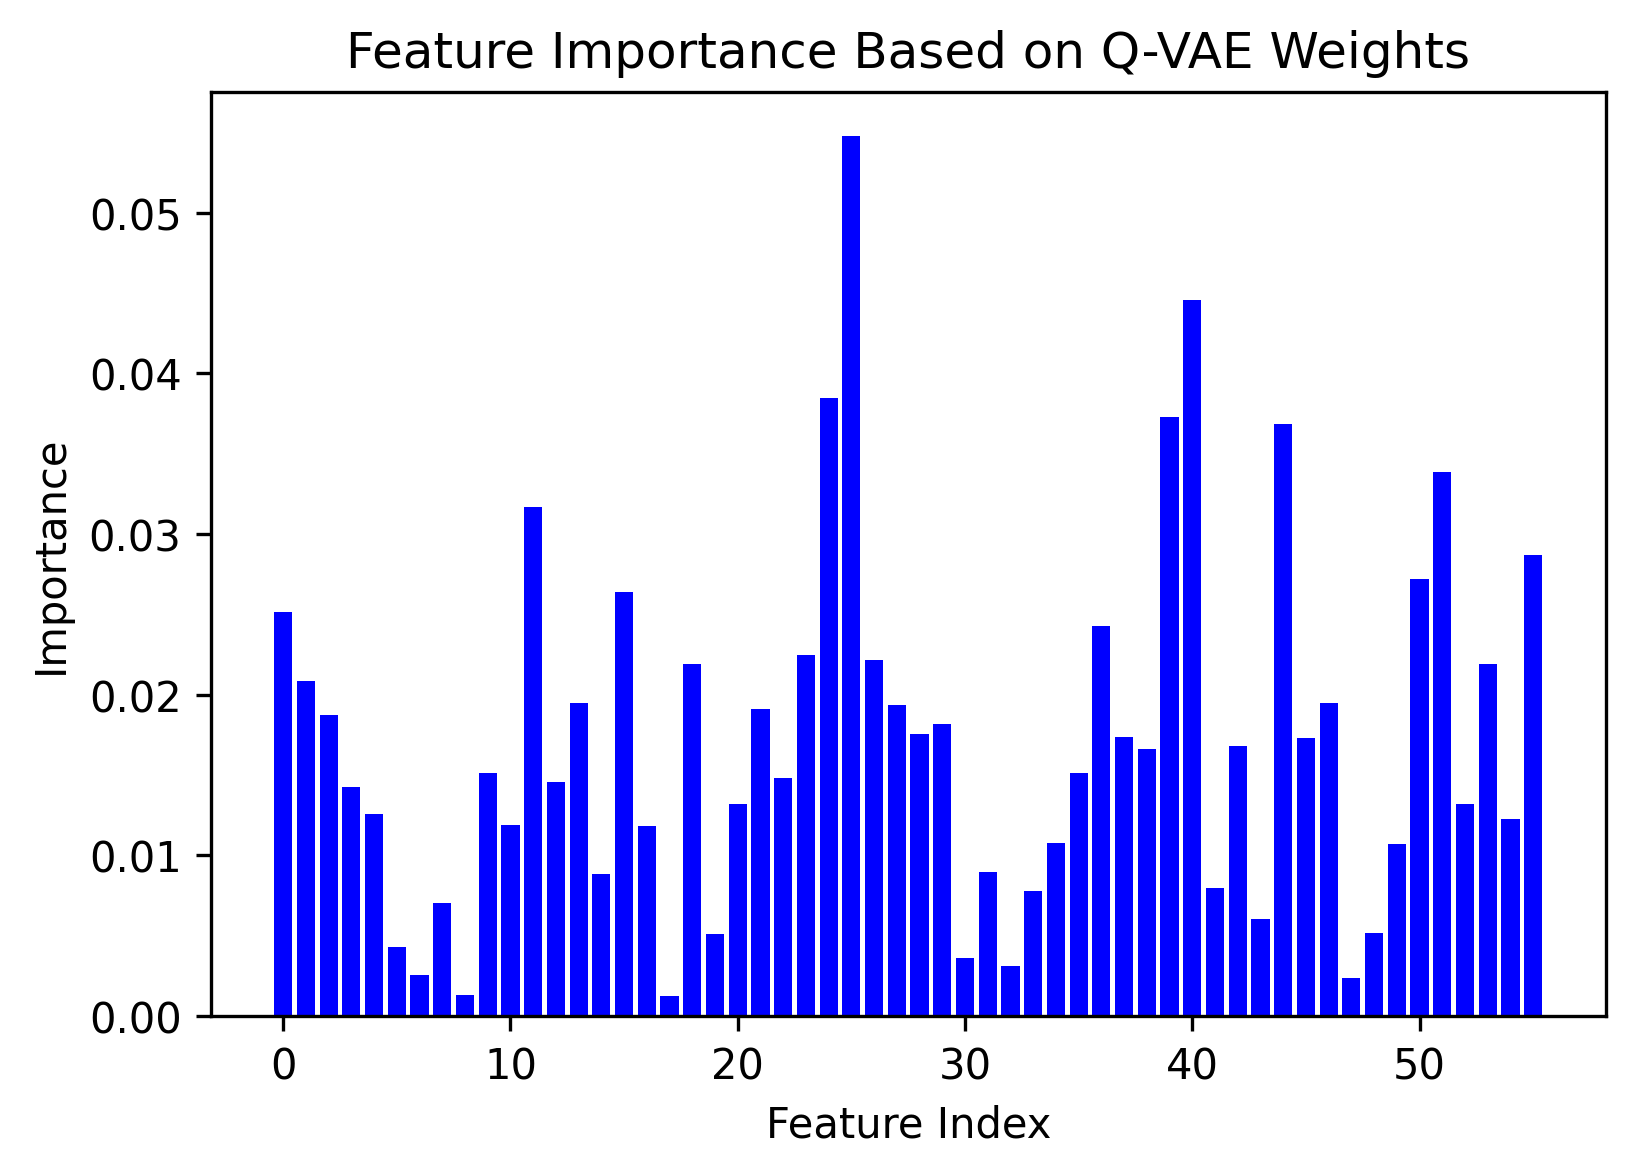

Weights shape: (56,)
First few weights: [-0.02513396  0.020842    0.01872018  0.01426453  0.01257673]


In [62]:
# Cell 13: Quantum Feature Importance
# Purpose: Analyze and visualize the importance of features based on Q-VAE weights.
# ======================================================
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importance(qvae_model):
    """
    Plots the importance of features based on the Q-VAE weights.
    Modified for SamplerQNN objects.
    """
    try:
        # Use the trained model's weights.
        # For a NeuralNetworkClassifier, these are usually stored in the 'weights' attribute.
        weights = qvae_model.weights  # Adjust if your attribute name is different.
        num_features = weights.shape[0]  # Adjust based on your model's weight shape
        
        # Compute feature importance (for example, using the absolute values)
        feature_importance = np.abs(weights)
        
        # Create the bar plot
        plt.figure(figsize=(6, 4))
        plt.bar(range(num_features), feature_importance, color='blue')
        plt.xlabel('Feature Index')
        plt.ylabel('Importance')
        plt.title('Feature Importance Based on Q-VAE Weights')
        plt.savefig('figure_6_Feature_Importance_Based_on_Q-VAE_Weights.png', bbox_inches='tight', dpi=300)
        plt.show()
        display(Image(filename='figure_6_Feature_Importance_Based_on_Q-VAE_Weights.png'))
        
        # Print some diagnostics
        print("Weights shape:", weights.shape)
        print("First few weights:", weights[:5])
        
    except AttributeError as e:
        print(f"Error accessing model parameters: {e}")
        print("Please check your model structure and adjust the feature importance calculation accordingly.")

# Use the trained qvae_model 
plot_feature_importance(qvae_model)

/var/folders/71/l0m_98fs0mg7z7032qxwwdg80000gn/T/ipykernel_34269/703327412.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


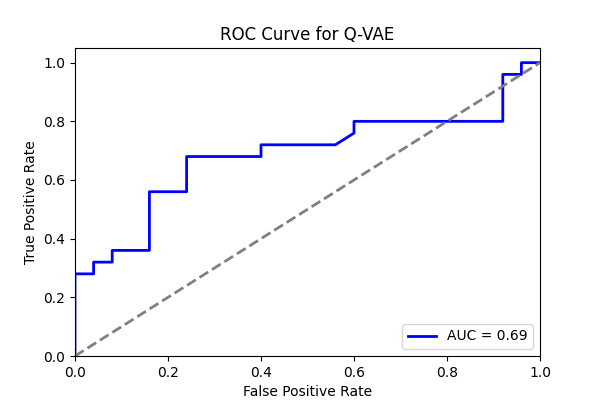

In [64]:
# Cell 14: ROC Curve & AUC Score
# Purpose: Plot the ROC curve and compute the AUC score for the Q-VAE model.
# ======================================================

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(qvae_model):
    """
    Plots the ROC curve and computes the AUC score for the Q-VAE model.
    """
    true_labels = qvae_model.true_labels
    anomaly_scores = qvae_model.anomaly_scores

    fpr, tpr, _ = roc_curve(true_labels, anomaly_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Q-VAE')
    plt.legend(loc="lower right")
    plt.savefig('figure_7_ROC Curve for Q-VAE.png')  
    plt.show()
    display(Image(filename='figure_7_ROC Curve for Q-VAE.png'))

# Assign test data from validation set 
X_test = validation_data
y_test = validation_labels

# Correct: slice X_test to include only the first few features expected by the circuit.
qvae_model.anomaly_scores = qvae_model.predict_proba(X_test[:, :len(input_params)])[:, 1]
qvae_model.true_labels = y_test

# Plot the ROC curve
plot_roc_curve(qvae_model)

/var/folders/71/l0m_98fs0mg7z7032qxwwdg80000gn/T/ipykernel_34269/1897667616.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


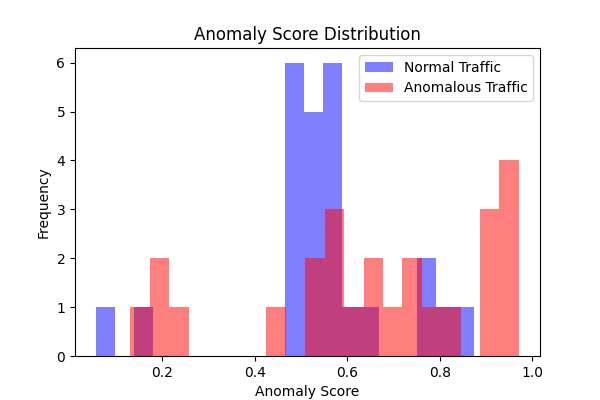

In [66]:
# Cell 15: Anomaly Score Distribution
# Purpose: Visualize the distribution of anomaly scores for normal and anomalous traffic.
# ======================================================

import matplotlib.pyplot as plt

def plot_anomaly_score_distribution(qvae_model):
    """
    Plots the distribution of anomaly scores for normal and anomalous traffic.
    """
    true_labels = qvae_model.true_labels
    anomaly_scores = qvae_model.anomaly_scores

    normal_scores = anomaly_scores[true_labels == 0]
    anomaly_scores = anomaly_scores[true_labels == 1]

    plt.figure(figsize=(6, 4))
    plt.hist(normal_scores, bins=20, alpha=0.5, color='blue', label='Normal Traffic')
    plt.hist(anomaly_scores, bins=20, alpha=0.5, color='red', label='Anomalous Traffic')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Frequency')
    plt.title('Anomaly Score Distribution')
    plt.legend()
    plt.savefig('figure_8_Anomaly Score Distribution.png')  # Save as specified
    plt.show()
    display(Image(filename='figure_8_Anomaly Score Distribution.png'))

# Plot anomaly score distribution
plot_anomaly_score_distribution(qvae_model)

In [ ]:
# Cell 16: Classical vs Quantum Model Comparison
# Purpose: Compare the accuracy of the Q-VAE model with a classical Random Forest model.
# ======================================================

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

def compare_classical_quantum(qvae_model, normal_traffic, anomaly_traffic, input_params):
    # Combine normal and anomalous data into one test set
    test_data = np.vstack((normal_traffic, anomaly_traffic))
    true_labels = np.array([0] * len(normal_traffic) + [1] * len(anomaly_traffic))

    # Use only the subset of features that were used in training (first len(input_params) columns)
    test_data_subset = test_data[:, :len(input_params)]
    
    # Recompute predictions for the full test_data using the Q-VAE model
    qvae_predictions = qvae_model.predict(test_data_subset)
    qvae_accuracy = accuracy_score(true_labels, qvae_predictions)

    # Classical model (Random Forest)
    # Train on normal traffic using only the relevant features
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(normal_traffic[:, :len(input_params)], [0] * len(normal_traffic))
    rf_predictions = rf_model.predict(test_data_subset)
    rf_accuracy = accuracy_score(true_labels, rf_predictions)

    # Plot the accuracy comparison
    plt.figure(figsize=(6, 4))
    plt.bar(['Quantum (Q-VAE)', 'Classical (Random Forest)'], [qvae_accuracy, rf_accuracy], 
            color=['blue', 'lightblue'])
    plt.ylabel('Accuracy')
    plt.title('Accuracy Comparison Between Q-VAE and Random Forest')
    plt.ylim(0, 1)
    plt.savefig('figure_9_Accuracy_Comparison_Between_Q-VAE_and_Random_Forest.png', 
                bbox_inches='tight', dpi=300)
    plt.show()

    return qvae_accuracy, rf_accuracy

# Run the comparison using your trained qvae_model, along with normal_traffic, anomaly_traffic, and input_params 
qvae_accuracy, rf_accuracy = compare_classical_quantum(qvae_model, normal_traffic, anomaly_traffic, input_params)
print(f"Q-VAE Accuracy: {qvae_accuracy:.2f}")
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")